## 在小型数据集上从头开始训练一个卷积神经网络

### 小型数据集的模型构建的策略
小型数据集：“很少的”样本可能是几百张图像，也可能是几万张图像。  
接下来的示例中，主要用来猫狗分类：4000张图片（2000猫，2000狗）
- 训练数据为：2000
- 验证数据：1000
- 测试数据：1000

对于小型数据集的基本策略如下：
- 据从头开始训练一个新模型，不做任何正则化，为模型目标设定一个基准，这里大概为71的精度
- 介绍数据增强（data augmentation）：网络精度将提高到 82%
- 用预训练的网络做特征提取：（得到的精度范围在 90%~96%）
- 对预训练的网络进行微调：（最终精度为 97%）


### 深度学习与小数据问题的相关性

所谓“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言。  
由于卷积神经网络学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据。

深度学习模型本质上具有高度的可复用性，比如，已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题。

### 从kaggle下载数据

[数据地址](https://www.kaggle.com/c/dogs-vs-cats/data)
但是这里需要我们先注册一个kaggle账号。具体的步骤可以参考如下这个博客,

这是我下载的数据:
![kaggle数据](imgs/06.jpg)
![训练数据](imgs/07.jpg)


In [5]:
import os,shutil

original_data_dir = "G:/Data/Kaggle/dogcat/train"
base_dir = "G:/Data/Kaggle/dogcat/smallData"
if os.path.isdir(base_dir) == False:
    os.mkdir(base_dir)

# 创建三个文件夹用来存放不同的数据:train,validation,test
train_dir = os.path.join(base_dir,'train')
if os.path.isdir(train_dir) == False:
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if os.path.isdir(validation_dir) == False:
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if os.path.isdir(test_dir) == False:
    os.mkdir(test_dir)
    
# 在文件中:train,validation,test分别创建cats,dogs文件夹用来存放对应的数据
train_cats_dir = os.path.join(train_dir,'cats')
if os.path.isdir(train_cats_dir) == False:
    os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir,'dogs')
if os.path.isdir(train_dogs_dir) == False:
    os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir,'cats')
if os.path.isdir(validation_cats_dir) == False:
    os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir,'dogs')
if os.path.isdir(validation_dogs_dir) == False:
    os.mkdir(validation_dogs_dir)
    
test_cats_dir = os.path.join(test_dir,'cats')
if os.path.isdir(test_cats_dir) == False:
    os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir,'dogs')
if os.path.isdir(test_dogs_dir) == False:
    os.mkdir(test_dogs_dir)


#将原始数据拷贝到对应的文件夹中 cat
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_data_dir,fname)
    dst = os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_data_dir,fname)
    dst = os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_data_dir,fname)
    dst = os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)
    
    
#将原始数据拷贝到对应的文件夹中 dog
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_data_dir,fname)
    dst = os.path.join(train_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_data_dir,fname)
    dst = os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_data_dir,fname)
    dst = os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)


In [2]:
print('train cat images:', len(os.listdir(train_cats_dir)))
print('train dog images:', len(os.listdir(train_dogs_dir)))
print('validation cat images:', len(os.listdir(validation_cats_dir)))
print('validation dog images:', len(os.listdir(validation_dogs_dir)))
print('test cat images:', len(os.listdir(test_cats_dir)))
print('test dog images:', len(os.listdir(test_dogs_dir)))

train cat images: 1000
train dog images: 1000
validation cat images: 500
validation dog images: 500
test cat images: 500
test dog images: 500


### 搭建网络模型

模型的搭建流程基本上都是 Conv2D+MaxPooling2D 的组合，要根据数据的大小可能需要更深的网络，以及最后的激活函数的选择。本实例中，初始的输入尺寸为150x150，最后计算在Flatten层之前的特征图大小为7x7.

这里可以参照VGG模型的套路:
- 特征图的深度在逐渐增大
- 增大可以按照2倍的方向增大:16,32,64,128...

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1,activation="sigmoid"))


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
# 选择优化器
from keras import optimizers

model.compile(loss= 'binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 数据预处理

根据之前的学习知道,在数据输入网络之前要将数据预处理成浮点张量数据,这里是JPGE文件,具体的处理流程如下:
- 读取图像文件
- 将JPGE文件读取成RGB像素点数据
- 将像素数据转化成浮点张量数据
- 将数值的范围缩放到[0,1]区间

在keras中利用 `keras.preprocessing.image`模块,自动批量转换.：它生成了 150×150 的 RGB 图像［形状为 (20, 150, 150, 3)］与二进制标签［形状为 (20,)］组成的批量。每个批量中包含 20 个样本（批量大小）。

我们让模型对数据进行拟合。我们将使用 fit_generator 方法来拟合,使用 fit_generator 时，你可以传入一个 validation_data 参数，其作用和在 fit 方法中类似。

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 它生成了 150×150 的 RGB 图像
#［形状为 (20, 150, 150, 3)］
#与二进制标签［形状为 (20,)］组成的批量

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# 利用批量生成器拟合模型

#  steps_per_epoch 参数的作用：从生成器中抽取 
# steps_per_epoch 个批量后拟合过程
# 每个批量包含 20 个样本，所以读取完所有 2000 个样本需要 100个批量

# validation_steps:需要从验证生成器中抽取多少个批次用于评估

将进入下一个轮次
history = model.fit_generator( 
      train_generator, 
      steps_per_epoch=100, 
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 9s 86ms/step - loss: 0.6330 - acc: 0.6365 - val_loss: 0.6518 - val_acc: 0.6260
Epoch 2/30
100/100 [==============================] - 8s 80ms/step - loss: 0.5888 - acc: 0.6875 - val_loss: 0.6220 - val_acc: 0.6260
Epoch 3/30
100/100 [==============================] - 8s 78ms/step - loss: 0.5538 - acc: 0.7145 - val_loss: 0.5992 - val_acc: 0.6780
Epoch 4/30
100/100 [==============================] - 8s 78ms/step - loss: 0.5421 - acc: 0.7140 - val_loss: 0.5736 - val_acc: 0.6930
Epoch 5/30
100/100 [==============================] - 8s 78ms/step - loss: 0.4963 - acc: 0.7550 - val_loss: 0.5752 - val_acc: 0.6920
Epoch 6/30
100/100 [==============================] - 8s 78ms/step - loss: 0.4793 - acc: 0.7710 - val_loss: 0.5600 - val_acc: 0.6850: 0.4792 - acc: 0.
Epoch 7/30
100/100 [==============================] - 8s 80ms/step - loss: 0.4715 - acc: 0.7660 - val_loss: 0.5627 - val_acc: 0.7040
Epoch 8/30
100/100 [==============================]

In [12]:
#保存模型
model.save('cats_and_dogs_small_data_1.h5')

### 结果比较
从这些图像中都能看出过拟合的特征。训练精度随着时间线性增加，直到接近 100%，而验证精度则停留在 70%~72%。验证损失仅在 5 轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于 0

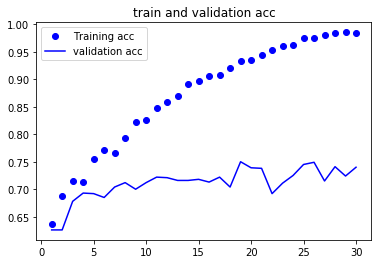

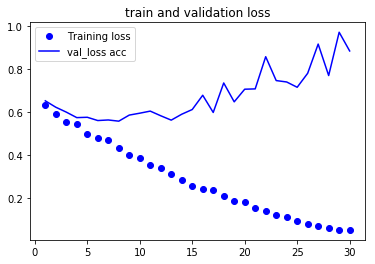

In [15]:
# 　绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('train and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='val_loss acc')
plt.title('train and validation loss')
plt.legend()

plt.show()

